In [ ]:
Taken from book "Statistics and Data Analysis for Financial Engineering" by David Ruppert and David S.Matteson
CH12 Time Series Models: 12.15 R Lab

In [54]:
# Load in the libraries
import pandas as pd

import matplotlib.pyplot as plt

from scipy import stats

import statsmodels.api as sm
import statsmodels.tsa as tsa

from statsmodels.tsa.stattools import coint, adfuller,acf, pacf,arma_order_select_ic
from statsmodels.stats.stattools import jarque_bera 
from statsmodels.stats.diagnostic import acorr_ljungbox as box

In [4]:
# Load in data
data = pd.read_csv("TbGdpPi.csv")

In [5]:
data.head()

,r,y,pii
0,1.41,7.894976,0.000000
1,1.47,7.911123,0.000000
2,2.15,7.924480,0.749064
3,2.50,7.930480,-0.371747
4,2.30,7.926614,0.000000


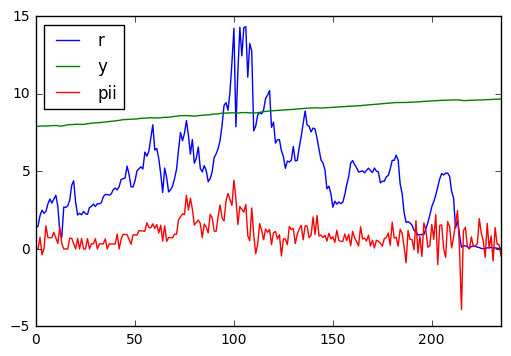

In [6]:
data.plot()
plt.show()

Are they stable?

In [11]:
def check_for_stationarity(X, cutoff=0.01):
    #X can be a pd.Series
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant small p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        return False
    
check_for_stationarity(data.r)    
check_for_stationarity(data.y)
check_for_stationarity(data.pii)  

p-value = 0.494233208128 The series r is likely non-stationary.
p-value = 0.5575129626 The series y is likely non-stationary.
p-value = 0.388973072742 The series pii is likely non-stationary.


False

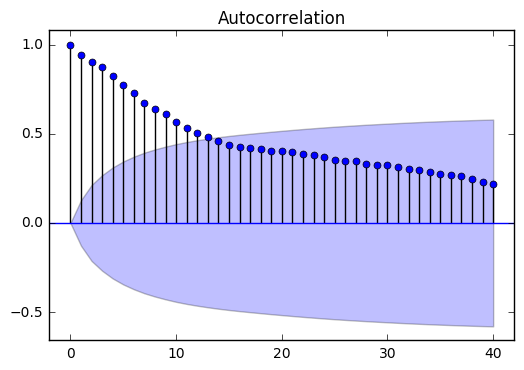

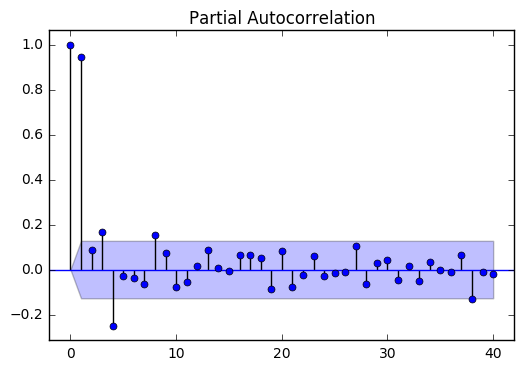

In [63]:
fig = sm.graphics.tsa.plot_acf(data.r, lags=40)
fig = sm.graphics.tsa.plot_pacf(data.r, lags=40)
plt.show()

Ljung-Box Test
The null hypothesis of the Ljung–Box test is H0 : ρ(1) = ρ(2) = · · · = ρ(K) = 0 for some K, say K = 5 or 10. If the Ljung– Box test rejects(very small p value), then we conclude that one or more of ρ(1), ρ(2), · · · , ρ(K) is nonzero.

In [61]:
box(data['r'],lags= 10,boxpierce=True)


(array([  212.98828893,   407.67305146,   592.71778255,   756.31485966,
          900.74394   ,  1029.90740064,  1140.76919424,  1240.57887269,
         1332.82628594,  1413.11109469]),
 array([  3.06145053e-048,   2.98484419e-089,   3.82000356e-128,
          2.22399857e-162,   1.83698285e-192,   3.03838368e-219,
          4.52756317e-242,   1.63476243e-262,   2.51299139e-281,
          1.46440352e-297]),
 array([  210.3035626 ,   401.71631231,   582.87354906,   742.3463301 ,
          882.52749632,  1007.34932802,  1114.01886892,  1209.63486341,
         1297.61874075,  1373.85557595]),
 array([  1.17933523e-047,   5.86693311e-088,   5.20100676e-126,
          2.35660961e-159,   1.60870257e-188,   2.30073956e-214,
          2.74730267e-236,   7.94336377e-256,   1.01107131e-273,
          4.37540140e-289]))

Conclusion: None of the three processes is stable.


In [44]:
r_diff = data['r'].diff().dropna()
check_for_stationarity(r_diff) 

p-value = 4.24724664789e-06 The series r is likely stationary.


True

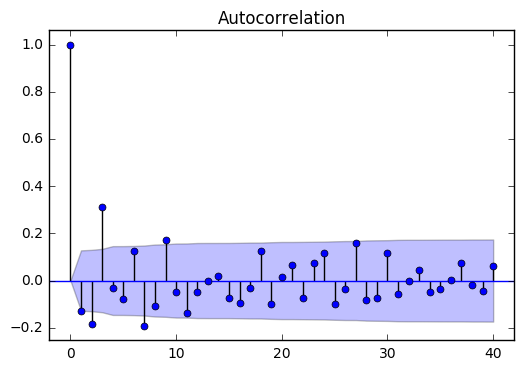

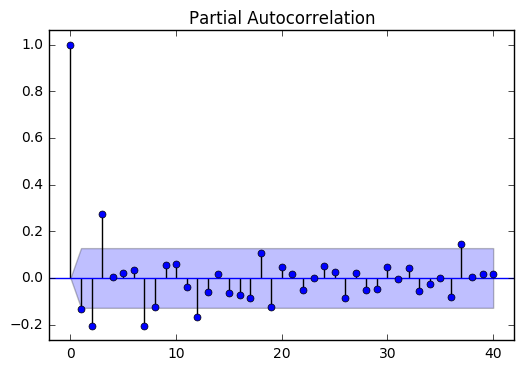

In [64]:
fig1 = sm.graphics.tsa.plot_acf(r_diff, lags=40)
fig2 = sm.graphics.tsa.plot_pacf(r_diff, lags=40)
plt.show()

Guess: p=3,q=3, we will try to fit model ARMA(3,3) or:


In [65]:
arma_order_select_ic(r_diff, max_ar=3, max_ma=3, ic='bic')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [66]:
#Fittin a ARMA model
arma_model = sm.tsa.ARMA(r_diff.values,(3,3)).fit()

print('Parameters:')
print(arma_model.params)
print('Standard Error:')
print(arma_model.bse)
print("AIC:")
print(arma_model.aic)


Parameters:
[-0.00521517 -0.20690671 -0.15870642  0.43986335  0.1296122  -0.00661778
 -0.2236603 ]
Standard Error:
[ 0.05470891  0.28888875  0.23659783  0.21112234  0.30391695  0.22515007
  0.20836072]
AIC:
614.617979099925


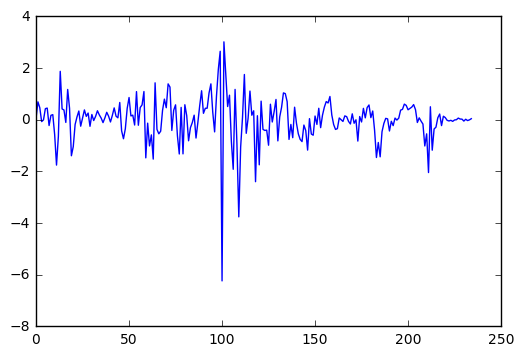

In [57]:
plt.plot(arma_model.resid)
plt.show()

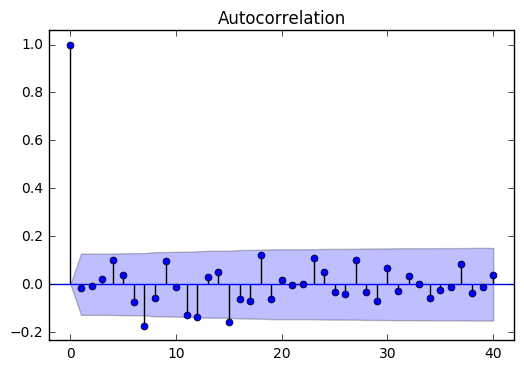

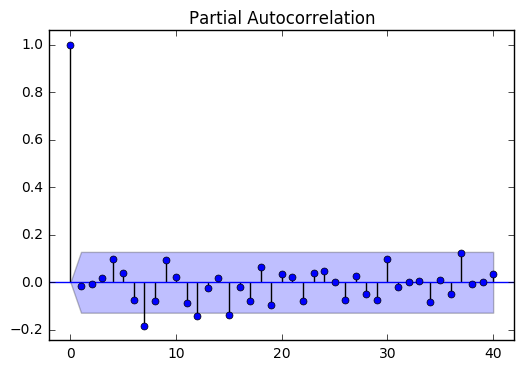

In [67]:
fig1 = sm.graphics.tsa.plot_acf(arma_model.resid, lags=40)
fig2 = sm.graphics.tsa.plot_pacf(arma_model.resid, lags=40)
plt.show()


In [68]:
sm.stats.durbin_watson(arma_model.resid)

2.0273347096827403

In [69]:
score, pvalue, _, _ = jarque_bera(arma_model.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print("The residuals seem normally distributed.")

We have reason to suspect the residuals are not normally distributed.


In [70]:
stats.normaltest(arma_model.resid)

NormaltestResult(statistic=127.06918726984205, pvalue=2.5543274726574684e-28)

In [71]:
box(arma_model.resid,lags= 10,boxpierce=True)

(array([  0.04457358,   0.05683189,   0.15520275,   2.53705945,
          2.8589889 ,   4.22907489,  11.77158333,  12.52692955,
         14.85660048,  14.89582255]),
 array([ 0.83279007,  0.97198399,  0.98447482,  0.63801225,  0.72171468,
         0.64570742,  0.10832514,  0.12919639,  0.09495098,  0.13590639]),
 array([  0.04400936,   0.05606078,   0.1523563 ,   2.47391283,
          2.78633381,   4.11017218,  11.36625625,  12.08973132,
         14.31127406,  14.3485102 ]),
 array([ 0.8338362 ,  0.97235882,  0.98488717,  0.64931312,  0.73288568,
         0.66176995,  0.12342182,  0.14724497,  0.11167545,  0.15768019]))